<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLDM-2022/blob/master/02-linear-regression/LinearRegression_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Task 1 (3 points)

Consider the following toy dataset:

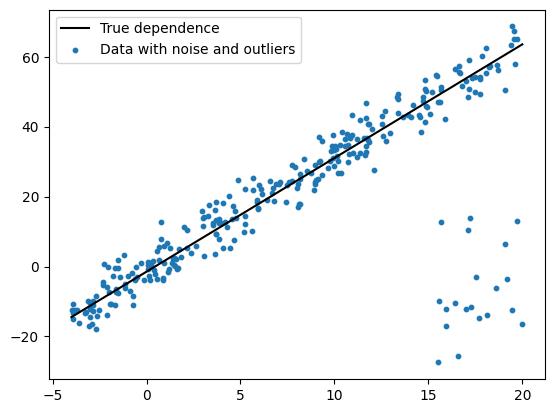

In [2]:
true_function = lambda x: 3.25 * x - 1.47
noize_function = lambda x: (
    np.random.normal(size=len(x)) * 4. +
    np.where(
        x < 15,
        0.,
        -60 + np.random.normal(size=len(x)) * 10
    ) * (np.random.uniform(size=len(x)) < 0.4).astype(int)
)
limits = (-4., 20.)

def generate_dataset(N=300):
  x = np.random.uniform(*limits, size=N)
  y = true_function(x) + noize_function(x)

  return x[:,None], y

X, y = generate_dataset()

x = np.linspace(*limits, 101)
plt.plot(x, true_function(x), c='black', label='True dependence')
plt.scatter(X, y, s=10, label='Data with noise and outliers')
plt.legend();

Implement a linear model $\hat y(x|w) = w_1\cdot x + w_0$ with MAE loss:
$$\text{MAE}(w) = \frac{1}{N}\sum_{i=1}^N\left|y_i - \hat y(x_i|w)\right|,$$
using gradient descent optimization in `numpy`.

*Hint: introduce a constant feature to account for the bias term to make the formulas simpler.*

Plot the learning curve and the final fit. Also, fit the same data with `sklearn`'s `LinearRegression`, and compare the two fits on the same plot. What do you observe? Write a short comment.

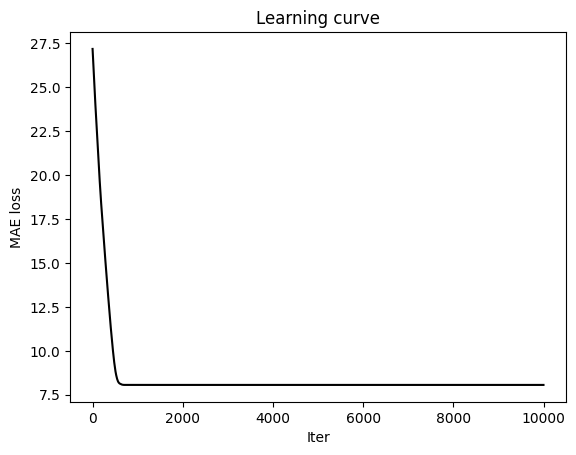

In [3]:
def MAE_loss(y, y_pred):
    return np.mean(np.abs(y - y_pred))



def GD(x, y, n_iter=50, lr=0.001):
    x_b = np.column_stack((x, np.ones(x.shape[0])))
    w = np.random.randn(x_b.shape[1])

    N = x_b.shape[0]
    loss = []
    
    for _ in range(n_iter):
        sig = np.sign(x_b @ w - y)
        grad = np.sum(x_b *  sig.reshape(N, 1)) / N
        w -= lr * grad
        loss.append(MAE_loss(y, x_b @ w))
 
    fig = plt.figure()
    ax = fig.gca()
    ax.set_xlabel("Iter")
    ax.set_ylabel("MAE loss")
    ax.set_title("Learning curve")
    plt.plot(range(n_iter), loss, c='black', label='True dependence')


    return w


learned_w = GD(X, y, 10000)

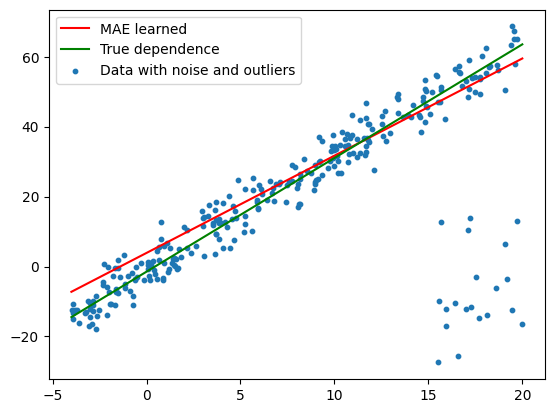

In [4]:
plt.plot(x, np.column_stack((x, np.ones(x.shape[0])))@learned_w, c='red', label='MAE learned')
plt.plot(x, true_function(x), c='green', label='True dependence')
plt.scatter(X, y, s=10, label='Data with noise and outliers')
plt.legend()

In [5]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, y)

LinearRegression()

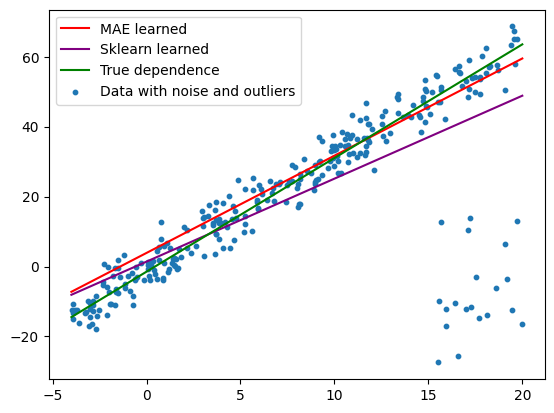

In [6]:
plt.plot(x, np.column_stack((x, np.ones(x.shape[0])))@learned_w, c='red', label='MAE learned')
plt.plot(x, np.column_stack((x, np.ones(x.shape[0])))@ np.append(model.coef_, model.intercept_) , c='purple', label='Sklearn learned')
plt.plot(x, true_function(x), c='green', label='True dependence')
plt.scatter(X, y, s=10, label='Data with noise and outliers')
plt.legend()

### Task comments

From the plots above we can see that both sklearn and out model has problems because of outliers.
But our model perform a bit better, it can happen because sklearn use MSE loss and this kind of loss more sensitive to outliers.

## Task 2 (2 + 1 points)

* Wrap your solution from the previous task into a class. Plot the learning curve and the final fit. Compare and comment your results with the previos ones. **(2 points)**

* Make it possible to choose a loss function. **(1 point)**

In [7]:
from sklearn.base import BaseEstimator, RegressorMixin

In [8]:
class LinearRergessionSGD(BaseEstimator, RegressorMixin):
    def __init__(self, loss_func='MAE', verbose=False, lr=0.001, n_iter=1000):
        self.loss_func = loss_func
        self.verbose = verbose
        self.lr = lr
        self.n_iter = n_iter

    def mae_loss(self):
        return np.mean(np.abs(y - self.x_b @ self.w))
    
    def mse_loss(self):
        return np.mean((y - self.x_b @ self.w) ** 2)
    
    def mae_grad(self):
        sig = np.sign(self.x_b @ self.w - y)
        return np.sum(self.x_b *  sig.reshape(self.N, 1)) / self.N
    
    def mse_grad(self):
        return -2/self.N * np.sum((self.y - self.x_b @ self.w) @ self.x_b)

    def fit(self, x, y):
        self.x_b = np.column_stack((x, np.ones(X.shape[0])))
        self.w = np.random.randn(self.x_b.shape[1])
        self.y = y
        self.N = self.x_b.shape[0]
        self.loss = []
        
        for _ in range(self.n_iter):
            if self.loss_func == 'MAE':
                grad = self.mae_grad()
            elif self.loss_func == 'MSE':
                grad = self.mse_grad()
            else:
                raise Exception("Unsupported loss")
            
            self.w -= self.lr * grad
            
            if self.loss_func == 'MAE':
                self.loss.append(self.mae_loss())
            elif self.loss_func == 'MSE':
                self.loss.append(self.mse_loss())
            else:
                raise Exception("Unsupported loss")

        if self.verbose:
            fig = plt.figure()
            ax = fig.gca()
            ax.set_xlabel("Iter")
            ax.set_ylabel(f"{self.loss_func} loss")
            ax.set_title("Learning curve")
            plt.plot(range(self.n_iter), self.loss, c='black', label='True dependence')

    def predict(self, x):
        return np.column_stack((x, np.ones(x.shape[0]))) @ self.w
    
    def fit_predict(self, x, y):
        self.fit(x, y)
        return self.predict(x)

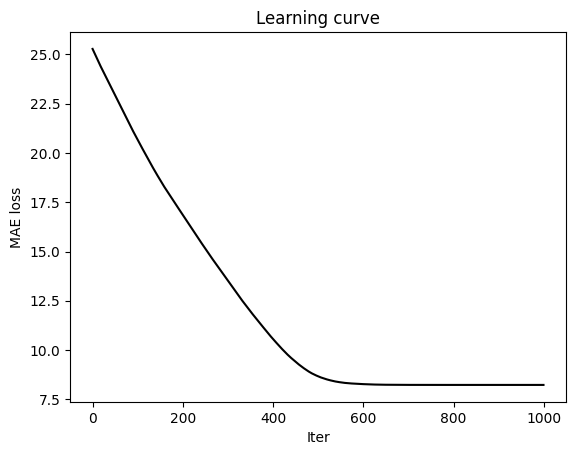

In [9]:
model_mae = LinearRergessionSGD(verbose=True)
model_mae.fit(X, y)

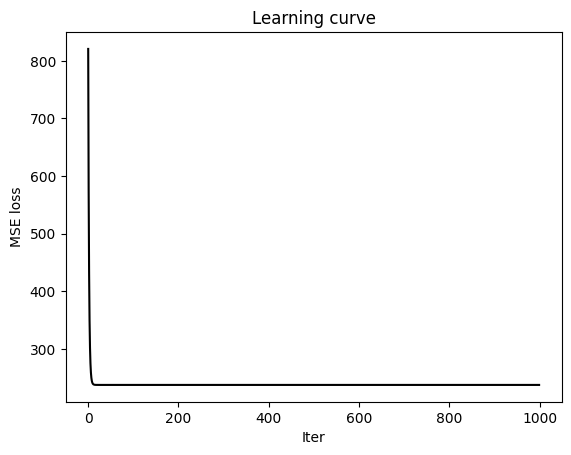

In [10]:
model_mse = LinearRergessionSGD(verbose=True, loss_func='MSE')
model_mse.fit(X, y)

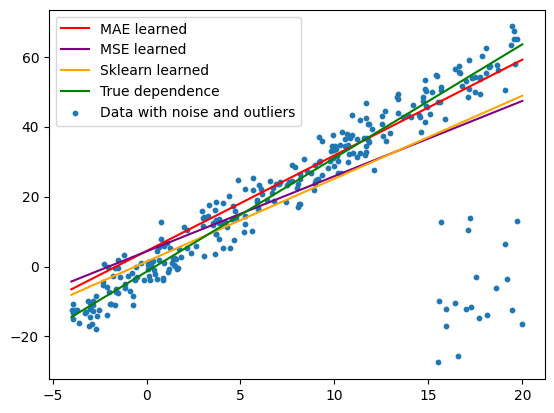

In [11]:
plt.plot(x, np.column_stack((x, np.ones(x.shape[0])))@model_mae.w, c='red', label='MAE learned')
plt.plot(x, np.column_stack((x, np.ones(x.shape[0])))@model_mse.w, c='purple', label='MSE learned')
plt.plot(x, np.column_stack((x, np.ones(x.shape[0])))@ np.append(model.coef_, model.intercept_) , c='orange', label='Sklearn learned')
plt.plot(x, true_function(x), c='green', label='True dependence')
plt.scatter(X, y, s=10, label='Data with noise and outliers')
plt.legend()

### Comments for task2

The current results support the comments on past work. The sklearn implementation uses MSE loss which is more sensitive to outliers and therefore its graph is biased towards outliers. The same behavior is shown by our own implementation based on MSE loss, you can see that the graphs are almost identical. MAE loss shows the best behavior, it is closest to the correct curve because it is less sensitive to outliers. It is also slightly shifted to outliers, but not so much. 
